# Leaves Shape Classification

### Contents

1. Extract the outline of leaves from pictures

2. Compute the dilation invariant coefficients of EFA

3. Apply PCA to the coefficients of EFA

4. Apply SVM to separate type 4 leaf and type 10 leaf

5. Use KNN (K-Nearest Neighbors) to classify test data

6. Apply K-fold cross-validation to verify the model

In [1]:
import cv2;
import numpy as np;
from matplotlib import pyplot as plt
import math
from sklearn.decomposition import PCA

In [2]:
#this jupyter note book use python version 3.7.6
from platform import python_version

print(python_version())

3.7.6


## Extract the outline of leaves from pictures

#### The fisrt 10 samples of leaves of type 1 tree

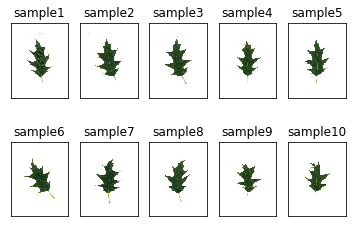

In [3]:
import matplotlib.image as mpimg
tree = 1
for pic_index in range(1, 11):
    file = 'tree' + str(tree) + '/' + 'tree' + str(tree) + 'leaf' + str(pic_index) + 'resizedcroppedcenteredWhite.png'
    img=mpimg.imread(file)
    plt.subplot(2,5,pic_index),plt.imshow(img),plt.title('sample'+str(pic_index))
    plt.xticks([]), plt.yticks([])
plt.savefig('sample.png')
plt.show()

#### Sample leaves of each type of tree

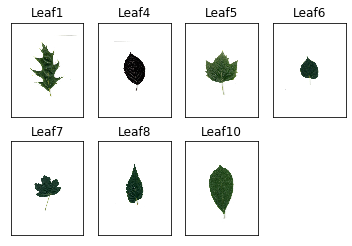

In [4]:
import matplotlib.image as mpimg

treelist = [1, 4, 5, 6, 7, 8, 10]

pic_index = 1
index = 0
for tree in treelist:
    index = index + 1
    file = 'tree' + str(tree) + '/' + 'tree' + str(tree) + 'leaf' + str(pic_index) + 'resizedcroppedcenteredWhite.png'
    img=mpimg.imread(file)
    plt.subplot(2,4,index),plt.imshow(img),plt.title('Leaf'+str(tree))
    plt.xticks([]), plt.yticks([])
plt.savefig('sample.png')
plt.show()

#### Find the countours of all sample leaves

In [5]:
# extract contour of leaves from pictures. Input: 'tree':tree_index, 'pic_index'
def extract_contour(tree, pic_index):
    file = 'tree' + str(tree) + '/' + 'tree' + str(tree) + 'leaf' + str(pic_index) + 'resizedcroppedcenteredWhite.png'
    #read the gray scale of the image
    im_in = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
    #find the contour
    #OTSU's watershed
    thresh = cv2.threshold(im_in, 60, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    #find the contour
    cnts,hierachy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #print(cnts)
    #cnts[0] is the image, cnts[1] the list of contour
    #find the longest contour
    L = 0
    contour = []
    for cont in cnts:
        if len(cont)>L:
            L = len(cont)
            contour = cont
    #read the x and y coordinates the contour
    x = np.zeros(len(contour))
    y = np.zeros(len(contour))
    for i in range(0, len(contour)):
        x[i] = contour[i][0][0]
        y[i] = -contour[i][0][1]
    Contour = [x, y]
    return Contour

In [6]:
#read the image data
treelist = [1, 4, 5, 6, 7, 8, 10]
ListContour = []
target = []

for tree in treelist:
    for pic_index in range(1, 11):
        Contour = extract_contour(tree, pic_index)
        if len(extract_contour(tree, pic_index)[0])>0:
            ListContour.append(extract_contour(tree, pic_index))
            target.append(tree)

## Compute the dilation invariant coefficients of EFA (Elliptic Fourier Analysis)

In [7]:
#EFA coeffs without multiply by T
def EFA_dilation_inv_Coeffs(x, y, harmonic):
    N = len(x)
    dx = np.zeros(N)
    dy = np.zeros(N)
    t = np.zeros(N)
    dt = np.zeros(N)
    A = np.zeros(harmonic)
    B = np.zeros(harmonic)
    C = np.zeros(harmonic)
    D = np.zeros(harmonic)

    dx[:N-1] = x[1:] - x[:N-1]
    dx[N-1] = x[0] - x[N-1]
    dy[:N-1] = y[1:] - y[:N-1]
    dy[N-1] = y[0] - y[N-1]
    for i in range(0, N):
        dt[i] = math.sqrt((dx[i])**2 + (dy[i])**2)
        t[i] = dt[i] + t[i-1]
    T = t[N-1]

    for n in range(1, harmonic+1):
        for p in range(0, N):
            A[n-1] = A[n-1] + 1/(2*n**2*math.pi**2)*dx[p]/dt[p]*(math.cos(2*math.pi*n*t[p]/T) - math.cos(2*math.pi*n*t[p-1]/T))
            B[n-1] = B[n-1] + 1/(2*n**2*math.pi**2)*dx[p]/dt[p]*(math.sin(2*math.pi*n*t[p]/T) - math.sin(2*math.pi*n*t[p-1]/T))
            C[n-1] = C[n-1] + 1/(2*n**2*math.pi**2)*dy[p]/dt[p]*(math.cos(2*math.pi*n*t[p]/T) - math.cos(2*math.pi*n*t[p-1]/T))
            D[n-1] = D[n-1] + 1/(2*n**2*math.pi**2)*dy[p]/dt[p]*(math.sin(2*math.pi*n*t[p]/T) - math.sin(2*math.pi*n*t[p-1]/T))
    coeffs = [A, B, C, D]
    return coeffs

In [8]:
#find coeffs by EFA_dilation_inv_Coeffs
harmonic = 40  #first 40 terms
ListCoeffs = []

for contour in ListContour:
    x = contour[0]
    y = contour[1]
    coeffs = EFA_dilation_inv_Coeffs(x, y, harmonic)
    ListCoeffs.append(coeffs)

## Apply PCA (Principal Component Analysis) to coefficients of EFA

In [9]:
#apply pca to coeffs
pca = PCA(n_components=2)
X = np.zeros([len(ListCoeffs), 4*harmonic])
for sample in range(0, len(ListCoeffs)):
    X[sample] = np.concatenate((ListCoeffs[sample][0], ListCoeffs[sample][1], ListCoeffs[sample][2], ListCoeffs[sample][3]))
pca.fit(X)
X_reduced = pca.fit_transform(X)

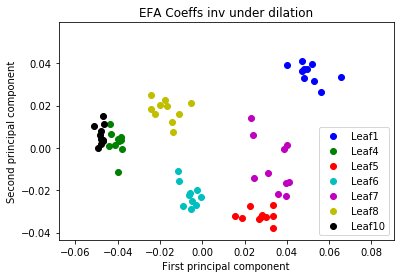

In [10]:
#plot the results of PCA
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
c_index = 0
for tree in treelist:
    indexes = [i for i,e in enumerate(target) if e == tree]
    plt.scatter(X_reduced[indexes,0], X_reduced[indexes,1], c = colors[c_index], label = 'Leaf'+str(tree))
    c_index += 1
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.axis('equal')
plt.legend()
plt.title('EFA Coeffs inv under dilation')
#plt.savefig('PCA_EFA.png')
plt.show()

In [11]:
print('The first two eigenvalues: {}, the explained variance: {}'.format(pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_)))

The first two eigenvalues: [0.55253152 0.21658569], the explained variance: 0.7691172157209483


In [12]:
#apply pca to absolute value of coeffs
pca_ab = PCA(n_components=2)
ListCoeffs_ab = np.absolute(ListCoeffs)
X_ab = np.zeros([len(ListCoeffs), 4*harmonic])
for sample in range(0, len(ListCoeffs)):
    X_ab[sample] = np.concatenate((ListCoeffs_ab[sample][0], ListCoeffs_ab[sample][1], ListCoeffs_ab[sample][2], ListCoeffs_ab[sample][3]))
pca_ab.fit(X_ab)
X_ab_reduced = pca_ab.fit_transform(X_ab)

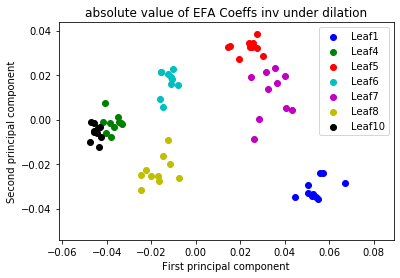

In [13]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
c_index = 0
for tree in treelist:
    indexes = [i for i,e in enumerate(target) if e == tree]
    plt.scatter(X_ab_reduced[indexes,0], X_ab_reduced[indexes,1], c = colors[c_index], label = 'Leaf'+str(tree))
    c_index += 1
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.axis('equal')
plt.legend()
plt.title('absolute value of EFA Coeffs inv under dilation')
plt.show()

In [14]:
print('The first two eigenvalues: {}, the explained variance: {}'.format(pca_ab.explained_variance_ratio_, sum(pca_ab.explained_variance_ratio_)))

The first two eigenvalues: [0.64003741 0.24088955], the explained variance: 0.880926957613758


In [15]:
#apply pca to coeffs components = 3
pca3 = PCA(n_components=3)
X3 = np.zeros([len(ListCoeffs), 4*harmonic])
for sample in range(0, len(ListCoeffs)):
    X[sample] = np.concatenate((ListCoeffs[sample][0], ListCoeffs[sample][1], ListCoeffs[sample][2], ListCoeffs[sample][3]))
pca3.fit(X)
X3_reduced = pca3.fit_transform(X)

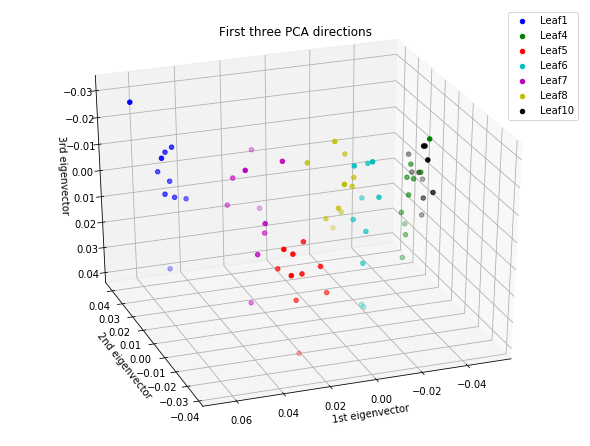

In [16]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
c_index = 0

for tree in treelist:
    indexes = [i for i,e in enumerate(target) if e == tree]
    ax.scatter(X3_reduced[indexes,0], X3_reduced[indexes,1], X3_reduced[indexes,2], c = colors[c_index], label = 'Leaf'+str(tree))
    c_index += 1
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
#ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
#ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
#ax.w_zaxis.set_ticklabels([])
plt.legend()

# rotate the axes and update
#for angle in range(0, 360):
#    ax.view_init(30, angle)
#    plt.draw()
#    plt.pause(.001)
    
plt.show()

In [17]:
print('The first three eigenvalues: {}, the explained variance: {}'.format(pca3.explained_variance_ratio_, sum(pca3.explained_variance_ratio_)))

The first three eigenvalues: [0.55253152 0.21658569 0.09520193], the explained variance: 0.8643191450712708


## Apply SVM to separate type 4 leaf and type 10 leaf

In [18]:
#we look at leaf4 and leaf10 and use higher order to seperate them
pca_4_10 = PCA(n_components=2)
indexes4 = [i for i,e in enumerate(target) if e == 4]
indexes10 = [i for i,e in enumerate(target) if e == 10]
X_4_10 = np.zeros([len(indexes4) + len(indexes10), 4*harmonic])
index_temp = 0
indexes4_new = []
indexes10_new = []
for index4 in indexes4:
    X_4_10[index_temp] = np.concatenate((ListCoeffs[index4][0], ListCoeffs[index4][1], ListCoeffs[index4][2], ListCoeffs[index4][3]))
    indexes4_new.append(index_temp)
    index_temp += 1
for index10 in indexes10:
    X_4_10[index_temp] = np.concatenate((ListCoeffs[index10][0], ListCoeffs[index10][1], ListCoeffs[index10][2], ListCoeffs[index10][3]))
    indexes10_new.append(index_temp)
    index_temp += 1
pca_4_10.fit(X_4_10)
X_4_10_reduced = pca_4_10.fit_transform(X_4_10)

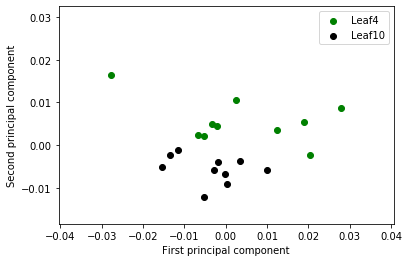

In [19]:
X_4_reduced = X_4_10_reduced[indexes4_new,0], X_4_10_reduced[indexes4_new,1]
X_10_reduced = X_4_10_reduced[indexes10_new,0], X_4_10_reduced[indexes10_new,1]

plt.scatter(X_4_reduced[0], X_4_reduced[1], c = 'g', label = 'Leaf'+str(4))
plt.scatter(X_10_reduced[0], X_10_reduced[1], c = 'k', label = 'Leaf'+str(10))

plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.legend()
plt.show()

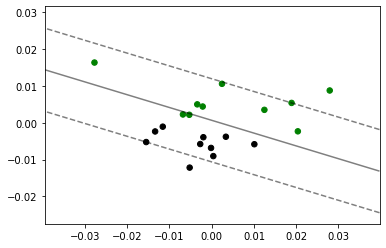

In [20]:
#use linear SVM to seperate Leaf4 and Leaf10
from sklearn import svm

Y = X_4_10_reduced
#label leaf 4 as 1, leaf 10 as -1
y = np.ones(len(indexes4_new) + len(indexes10_new))
y[indexes10_new] = -1

color = np.ones(len(indexes4_new) + len(indexes10_new), dtype = str)
color[indexes4_new] = 'g'
color[indexes10_new] = 'k'

clf = svm.SVC(kernel='linear')
# fit the model, don't regularize for illustration purposes
clf = svm.SVC(kernel='linear', C=1000)
clf.fit(Y, y)

plt.scatter(Y[:, 0], Y[:, 1], c=color, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], 
           linewidth=1, facecolors='none')
plt.show()

## Use KNN (K-Nearest Neighbors) to classify test data

#### Load test data

In [21]:
#read test data
test_treelist = [1, 4, 5, 6, 7, 8, 10]
test_ListContour = []
test_target = []

for tree in treelist:
    for pic_index in range(11, 20):
        Contour = extract_contour(tree, pic_index)
        if len(extract_contour(tree, pic_index)[0])>0:
            test_ListContour.append(extract_contour(tree, pic_index))
            test_target.append(tree)

In [22]:
#find coeffs by EFA_dilation_inv_Coeffs
harmonic = 40  #first 40 terms
test_ListCoeffs = []

for contour in test_ListContour:
    x = contour[0]
    y = contour[1]
    coeffs = EFA_dilation_inv_Coeffs(x, y, harmonic)
    test_ListCoeffs.append(coeffs)

#### Use KNN classifier

In [23]:
from sklearn.neighbors import KNeighborsClassifier

#reshape ListCoeffs to ndim = 2
def reshape_coeffs(ListCoeffs):
    X = []
    for i in range(len(ListCoeffs)):
        X.append(np.ravel(ListCoeffs[i]))
    return np.array(X)



In [24]:
#apply KNN to EFA coeff, here X is EFA coefficient
X_train = reshape_coeffs(ListCoeffs)
test_X = reshape_coeffs(test_ListCoeffs)

clf_KNN = KNeighborsClassifier(n_neighbors=5)
clf_KNN.fit(X_train, target)

yhat = clf_KNN.predict(test_X)
print('Precision:', (yhat==test_target).mean())



Precision: 0.7368421052631579


In [25]:
#apply KNN to PCA of EFA coeff
#Here we use pca.transform(). pca.fit_transform() is combination of fit() and transform(). We don't use fit() here.
X_train_pca = pca.transform(X_train)   
test_X_pca = pca.transform(test_X)

clf_KNN_pca = KNeighborsClassifier(n_neighbors=5)
clf_KNN_pca.fit(X_train_pca, target)

yhat_pca = clf_KNN_pca.predict(test_X_pca)
print('Precision: {}, explained variance: {}'.format((yhat_pca==test_target).mean(), sum(pca.explained_variance_ratio_)))


Precision: 0.7368421052631579, explained variance: 0.7691172157209483


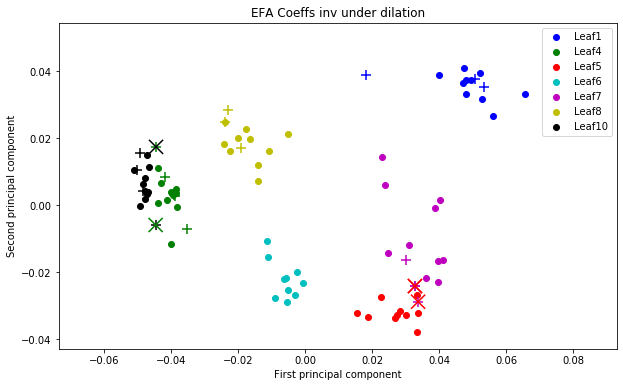

In [26]:
#plot the results of PCA
plt.figure(figsize = [10, 6])

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
c_index = 0
for tree in treelist:
    indexes = [i for i,e in enumerate(target) if e == tree]
    plt.scatter(X_train_pca[indexes,0], X_train_pca[indexes,1], c = colors[c_index], label = 'Leaf'+str(tree))
    c_index += 1

c_index = 0
for tree in treelist:
    indexes = [i for i,e in enumerate(test_target) if e == tree]
    plt.scatter(test_X_pca[indexes,0], test_X_pca[indexes,1], marker = '+', c = colors[c_index], s = 100)
    c_index += 1

#marker '+' correct label, marker 'x' wrong prediction
index_wrong = [i for i,x in enumerate(list(yhat_pca==test_target)) if x == False]
tag_wrong = [yhat_pca[i] for i in index_wrong]
color_wrong = [colors[treelist.index(i)] for i in tag_wrong]
plt.scatter(test_X_pca[index_wrong,0], test_X_pca[index_wrong,1],  marker = 'x',
            c = color_wrong, s = 200)
    
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.axis('equal')
plt.legend()
plt.title('EFA Coeffs inv under dilation')
#plt.savefig('PCA_EFA.png')
plt.show()

In [27]:
#apply KNN to PCA of ABSOLUTE values of EFA coeff 
X_train_pca_ab = pca_ab.transform(X_train)
test_X_pca_ab = pca_ab.transform(test_X)

clf_KNN_pca_ab = KNeighborsClassifier(n_neighbors=5)
clf_KNN_pca_ab.fit(X_train_pca_ab, target)

yhat_pca_ab = clf_KNN_pca_ab.predict(test_X_pca_ab)
print('Precision: {}, explained variance: {}'.format((yhat_pca_ab==test_target).mean(), sum(pca_ab.explained_variance_ratio_)))

Precision: 0.9473684210526315, explained variance: 0.880926957613758


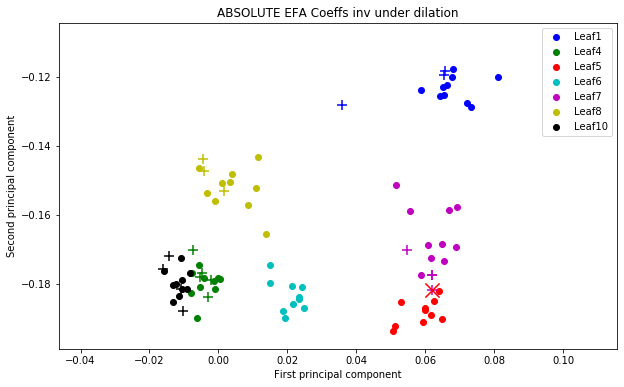

In [28]:
#plot the results of PCA
plt.figure(figsize = [10, 6])

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
c_index = 0
for tree in treelist:
    indexes = [i for i,e in enumerate(target) if e == tree]
    plt.scatter(X_train_pca_ab[indexes,0], X_train_pca_ab[indexes,1], c = colors[c_index], label = 'Leaf'+str(tree))
    c_index += 1

c_index = 0
for tree in treelist:
    indexes = [i for i,e in enumerate(test_target) if e == tree]
    plt.scatter(test_X_pca_ab[indexes,0], test_X_pca_ab[indexes,1], marker = '+', c = colors[c_index], s = 100)
    c_index += 1

index_wrong = [i for i,x in enumerate(list(yhat_pca_ab==test_target)) if x == False]
tag_wrong = [yhat_pca_ab[i] for i in index_wrong]
color_wrong = [colors[treelist.index(i)] for i in tag_wrong]
plt.scatter(test_X_pca_ab[index_wrong,0], test_X_pca_ab[index_wrong,1],  marker = 'x',
            c = color_wrong, s = 200)
    
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.axis('equal')
plt.legend()
plt.title('ABSOLUTE EFA Coeffs inv under dilation')
#plt.savefig('PCA_EFA.png')
plt.show()

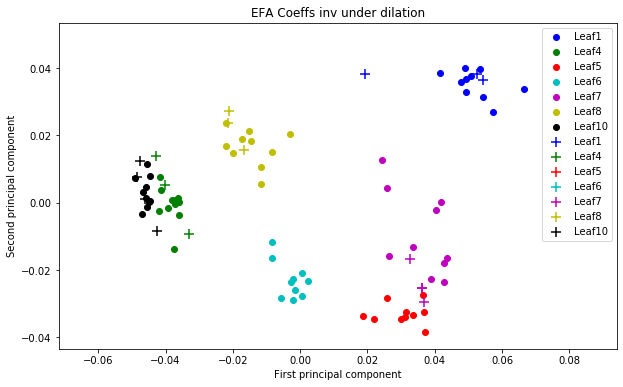

In [29]:
#We find the PCA of the combine of training set and test set
X_total = np.concatenate((X_train, test_X), axis = 0)
target_total = np.concatenate((target, test_target), axis = 0)

pca2 = PCA(n_components=2)
pca2.fit(X_total)
X_total_reduced = pca2.transform(X_total)


#plot the results of PCA
plt.figure(figsize = [10, 6])

#training data in 'dot'
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
c_index = 0
for tree in treelist:
    indexes = [i for i,e in enumerate(target) if e == tree]
    plt.scatter(X_total_reduced[indexes,0], X_total_reduced[indexes,1], c = colors[c_index], label = 'Leaf'+str(tree))
    c_index += 1
#test data in '+'
c_index = 0
for tree in treelist:
    indexes = [i+len(target) for i,e in enumerate(test_target) if e == tree]
    plt.scatter(X_total_reduced[indexes,0], X_total_reduced[indexes,1], marker = '+', 
                s=100, c = colors[c_index], label = 'Leaf'+str(tree))
    c_index += 1
    
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.axis('equal')
plt.legend()
plt.title('EFA Coeffs inv under dilation')
#plt.savefig('PCA_EFA.png')
plt.show()

In [30]:
#the difference of two different transformation (pca for train set and pca2 for total set)
pca.components_ - pca2.components_

array([[ 1.32082505e-02,  6.46109738e-03, -3.33769731e-03,
         2.29655055e-04,  1.22316894e-03,  2.29105535e-03,
         4.15282551e-03,  8.79902112e-04, -1.22313750e-03,
        -2.22945176e-03, -1.57162302e-03,  1.64555385e-03,
         7.16884852e-05,  1.57682418e-03,  1.97841239e-03,
         1.05291109e-03, -5.89176930e-05,  7.56022215e-04,
         7.98248910e-04,  3.06345902e-04,  1.82341994e-04,
        -7.89360388e-04, -5.71881876e-04,  2.66065255e-04,
        -1.95845017e-04, -1.94801402e-04, -3.05407233e-04,
        -3.23586653e-05, -4.84089277e-04, -2.20912976e-06,
        -1.02848405e-06,  3.64726171e-04, -1.06622412e-04,
        -2.03374033e-04,  2.17164389e-04,  1.03914799e-04,
         2.26111849e-05, -1.30782988e-04, -9.94032712e-05,
         2.08663809e-04,  2.15395403e-02, -2.56582063e-02,
         2.91484122e-03, -1.32788757e-03,  5.74214357e-03,
         1.58487869e-03,  3.62371112e-04, -8.57764004e-04,
        -1.49272299e-03, -3.40181582e-03, -1.34015156e-0

#### Observation from above 

If we apply PCA to the ABSOLUTE values of EFA coefficients, and apply KNN classifier to the resutls of PCA, then precision of the test set is 94.7%. We need to see if we change the train and test set, will the good precision preserves? We are going to use k-fold cross-validation to examine this.

## Apply K-fold cross-validation to verify the model

In [31]:
from sklearn.model_selection import KFold

#fine the absolute EFA coeff
X_total_ab = np.absolute(X_total)
y_total = np.array(target_total)

#list of pca componets, list of pca explained variance ratio, and list of precision
pca_ab_comp_list = []
pca_ab_evr_list = []
precision_list = []

#K-fold cross-validation
kf = KFold(n_splits=8, random_state = 42)
for train_index, test_index in kf.split(X_total_ab):
    X_train_ab_cv, X_test_ab_cv = X_total_ab[train_index], X_total_ab[test_index]
    y_train_cv, y_test_cv = y_total[train_index], y_total[test_index]
    #PCA
    pca_ab_cv = PCA(n_components=2)
    pca_ab_cv.fit(X_train_ab_cv)
    X_train_pca_ab_cv = pca_ab_cv.transform(X_train_ab_cv)
    X_test_pca_ab_cv = pca_ab_cv.transform(X_test_ab_cv)
    pca_ab_comp_list.append(pca_ab_cv.components_)
    pca_ab_evr_list.append(sum(pca_ab_cv.explained_variance_ratio_))
    #KNN
    clf_KNN_pca_ab_cv = KNeighborsClassifier(n_neighbors=5)
    clf_KNN_pca_ab_cv.fit(X_train_pca_ab_cv, y_train_cv)
    yhat_test_cv = clf_KNN_pca_ab_cv.predict(X_test_pca_ab_cv)
    precision_list.append((yhat_test_cv==y_test_cv).mean())



In [39]:
print('pca explained variance ratio:', pca_ab_evr_list)
print('precision:', precision_list)
print('average precision: ', np.array(precision_list).mean())

pca explained variance ratio: [0.8780082606644047, 0.888480094224453, 0.8967826645458443, 0.8964303539043729, 0.8948607441305336, 0.8843965360838973, 0.8844947036784447, 0.8843225529458423]
precision: [0.75, 0.8181818181818182, 0.6363636363636364, 1.0, 1.0, 0.9090909090909091, 0.9090909090909091, 0.9090909090909091]
average precision:  0.8664772727272727


It looks like the folds 1, 3, 5 have good predition. We average the transformation among the transformations of these three folds.

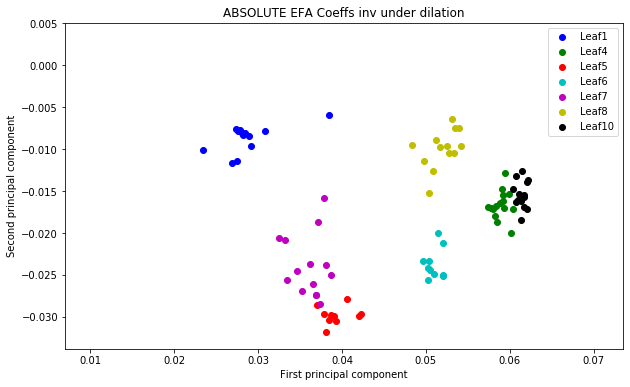

In [33]:
#average of pca componets of folds except for bad precision folds

select = [1,4,5]
pca_ab_comp_model = np.zeros_like(pca_ab_comp_list[0])
for i in select:
    #make sure the sign of left corner element of the transform matrix is non-negative
    if np.sign(pca_ab_comp_list[i][0][0]) < 0:
        pca_ab_comp_model = pca_ab_comp_model - pca_ab_comp_list[i]
    else:
        pca_ab_comp_model = pca_ab_comp_model + pca_ab_comp_list[i]
pca_ab_comp_model = pca_ab_comp_model/len(select)

#we use this model to see the precision among the total set
X_total_ab_pca_model = X_total_ab.dot(pca_ab_comp_model.T)

#plot the results of model
plt.figure(figsize = [10, 6])

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
c_index = 0
for tree in treelist:
    indexes = [i for i,e in enumerate(y_total) if e == tree]
    plt.scatter(X_total_ab_pca_model[indexes,0], X_total_ab_pca_model[indexes,1], c = colors[c_index], label = 'Leaf'+str(tree))
    c_index += 1

plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.axis('equal')
plt.legend()
plt.title('ABSOLUTE EFA Coeffs inv under dilation')
#plt.savefig('PCA_EFA.png')
plt.show()

In [34]:
#KNN to the model PCA of the total set
clf_KNN_pca_ab_model = KNeighborsClassifier(n_neighbors=5)
clf_KNN_pca_ab_model.fit(X_total_ab_pca_model, y_total)
yhat_model = clf_KNN_pca_ab_model.predict(X_total_ab_pca_model)
print('precision:', (yhat_model==y_total).mean())

precision: 0.9550561797752809


In [35]:
#use the model above as a fixed PCA transform
#use k-fold cross-validation for the model
precision_list_model = []

kf1 = KFold(n_splits=8, random_state = 4)
for train_index, test_index in kf1.split(X_total_ab_pca_model):
    X_train_pca_ab_cv, X_test_pca_ab_cv = X_total_ab_pca_model[train_index], X_total_ab_pca_model[test_index]
    y_train_cv, y_test_cv = y_total[train_index], y_total[test_index]
    #KNN
    clf_KNN_pca_ab_cv = KNeighborsClassifier(n_neighbors=5)
    clf_KNN_pca_ab_cv.fit(X_train_pca_ab_cv, y_train_cv)
    yhat_test_cv = clf_KNN_pca_ab_cv.predict(X_test_pca_ab_cv)
    precision_list_model.append((yhat_test_cv==y_test_cv).mean())

In [38]:
print('precision list: ', precision_list_model)
print('average precision: ', np.array(precision_list_model).mean())

precision list:  [0.75, 0.7272727272727273, 0.7272727272727273, 1.0, 1.0, 1.0, 0.9090909090909091, 0.9090909090909091]
average precision:  0.8778409090909092
